In [2]:
import pandas as pd
import numpy as np

# Format misc
import pickle

# Combine sets and calculate diversity
from scipy.stats import entropy

import itertools
from collections import Counter
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

from scipy.stats import pearsonr

# Plot
import seaborn as sns
import pylab as plt

sns.set(font_scale=1.3)
sns.set_style("white")

%matplotlib inline

In [3]:
#Colors
palette = ((255/255, 174/255, 143/255), (111/255, 158/255, 206/255))

In [4]:
!rm 'data_clean/all_people_hap.csv'

print("Uncompressing processed data (data_clean/all_people_hap) in order")
!unzip -p 'data_clean/all_people_hap_1.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_2.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_3.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_4.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_5.zip' >> data_clean/all_people_hap.csv
!unzip -p 'data_clean/all_people_hap_6.zip' >> data_clean/all_people_hap.csv

Uncompressing processed data (data_clean/all_people_hap) in order


In [5]:
#Read the cleaned data 
people = pd.read_csv("data_clean/all_people_hap.csv", sep="\t")

#For now, delete after
parties = ['AfD', 'Bündnis90/Die Grünen', 'CDU', 'CSU', 'Die Linke', 'FDP', 'SPD']
people["person"] = people["keyword"].apply(lambda x: x in parties)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
p = pd.read_csv("data_clean/all_people_entropy.csv", sep="\t")

news
AfD


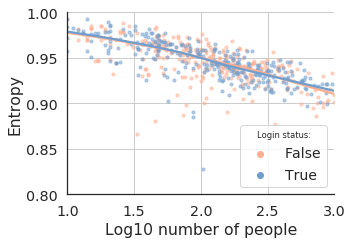

Alexander Gauland


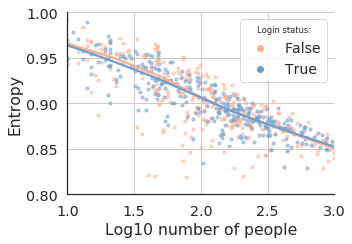

Alice Weidel


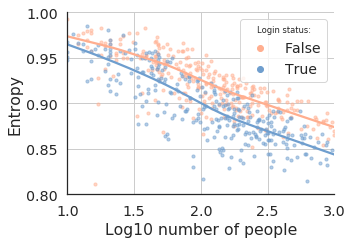

Angela Merkel


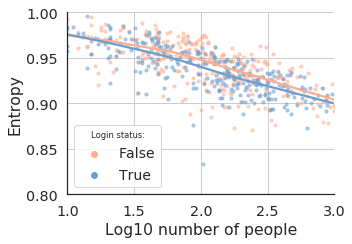

Bündnis90/Die Grünen


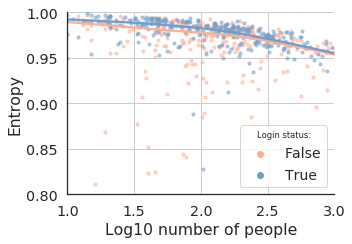

CDU


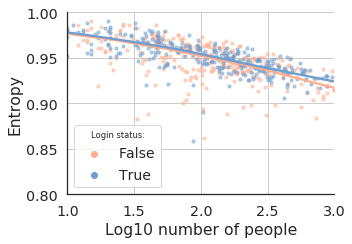

CSU


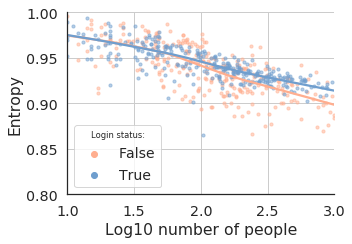

Cem Özdemir


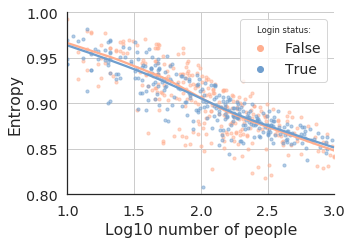

Christian Lindner


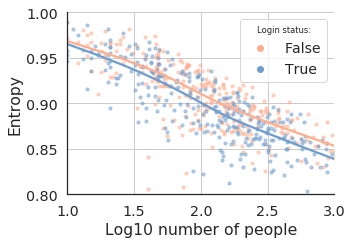

Die Linke


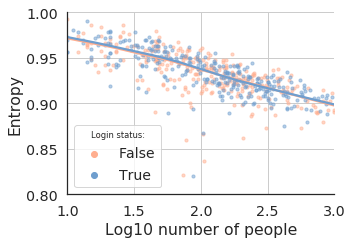

Dietmar Bartsch


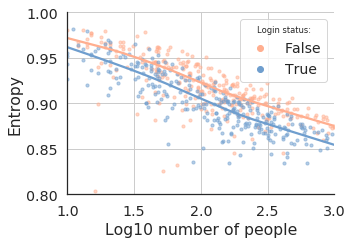

FDP


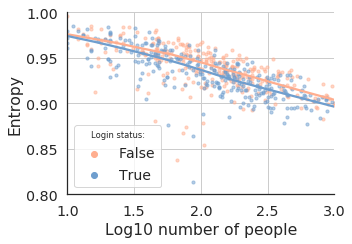

Katrin Göring-Eckardt


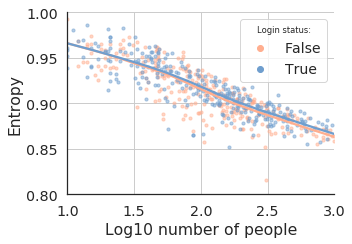

Martin Schulz


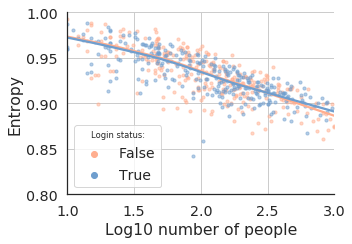

SPD


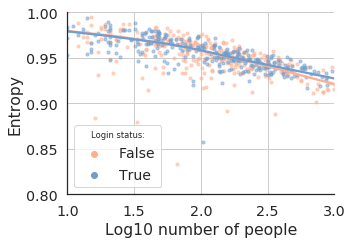

Sahra Wagenknecht


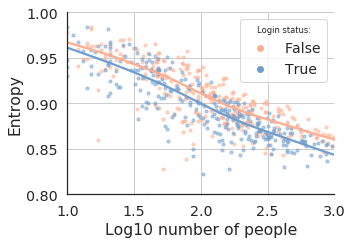

search
AfD


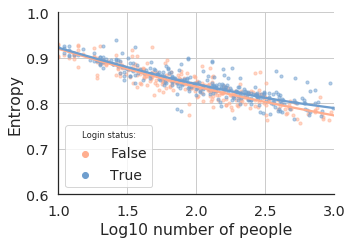

Alexander Gauland


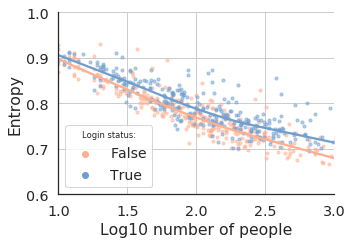

Alice Weidel


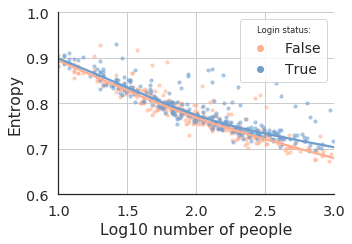

Angela Merkel


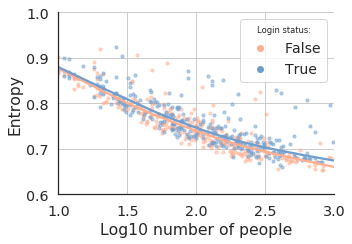

Bündnis90/Die Grünen


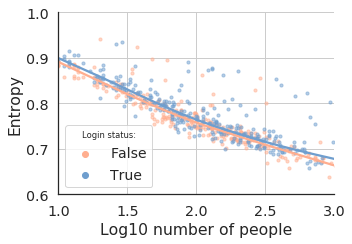

CDU


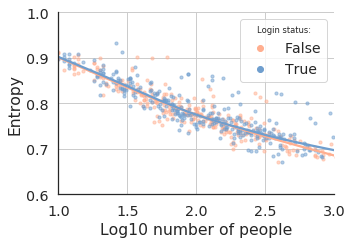

CSU


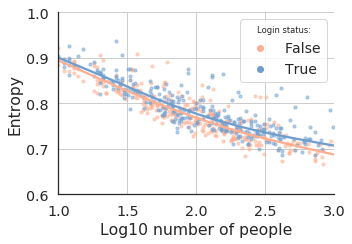

Cem Özdemir


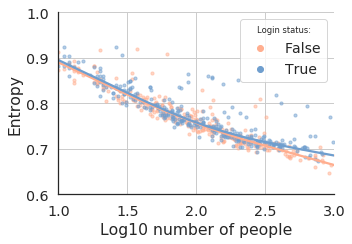

Christian Lindner


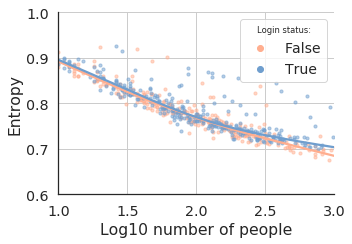

Die Linke


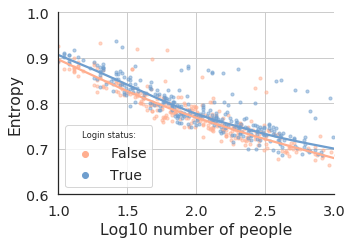

Dietmar Bartsch


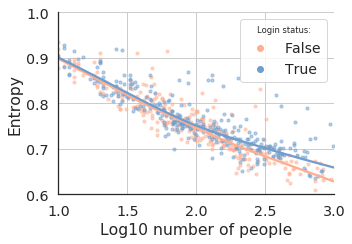

FDP


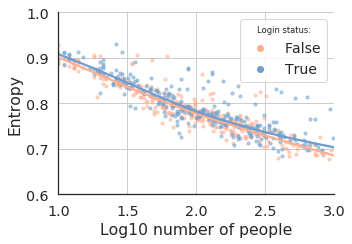

Katrin Göring-Eckardt


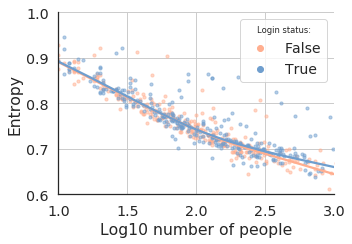

Martin Schulz


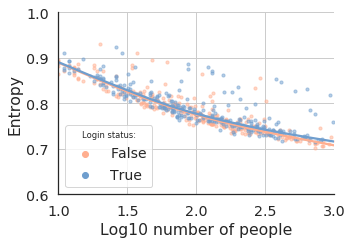

SPD


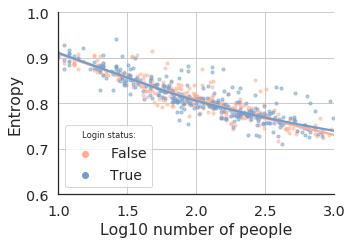

Sahra Wagenknecht


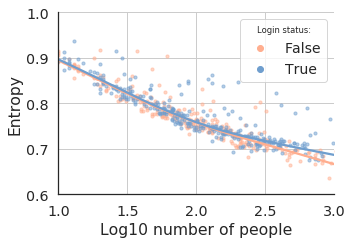

In [7]:
!mkdir -p figures

ress = []
for a,b in p.groupby("search_type"):
    print(a)
    for d,h in b.groupby(["keyword"]):
        print(d)
        plt.figure(figsize=(5, 3.5))
        for j,h2 in h.groupby("login_status"):
            
            if not j:
                color=palette[0]
            else:
                color=palette[1]
            sns.regplot("plugin_id", "result_hash", data=h2, truncate=True,
                        scatter_kws={"s":10, "alpha":0.5}, lowess=True, color=color) #,y_partial="plugin_id")         
            
            plt.scatter([0,0], [0,0], label=str(j), color=color)
                
            plt.xlabel("Log10 number of people")
            plt.ylabel("Entropy")
            
            ress.append((a, d, h2))

        plt.xlim(1, 3)
        if a == "search":
            plt.ylim(0.6, 1)
        else:
            plt.ylim(0.8, 1)
        
        sns.despine()
        plt.grid()
        legend = plt.legend(title="Login status:", fontsize=14)
        plt.setp(legend.get_title(), fontsize='small')
        plt.tight_layout()

        if d == "Alice Weidel":
            plt.savefig("figures/alice_{}.pdf".format(a))
        plt.show()

In [8]:
# Define parties
parties = ["AfD", "CDU", "CSU", "FDP", "Grüne", "Linke", "SPD"]

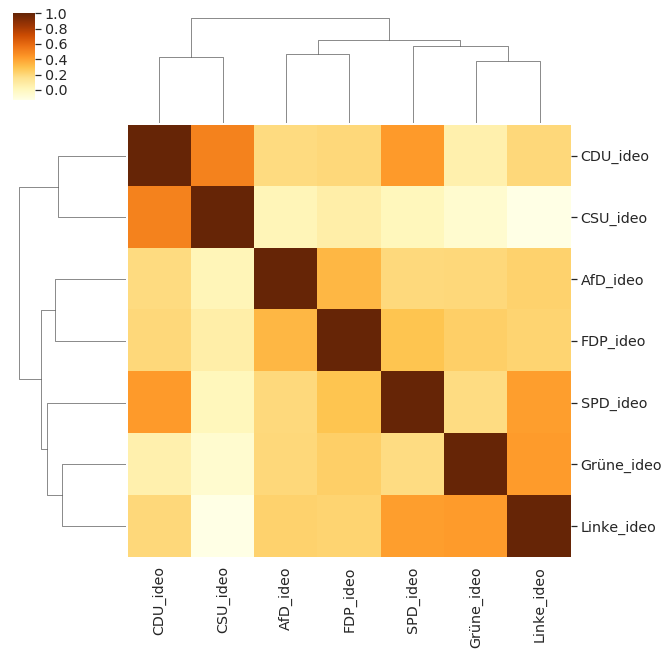

In [9]:
# Ideology between parties
person2party_code = {
    'Alexander Gauland': 'AfD',
    'Alice Weidel': 'AfD',
    'Angela Merkel': 'CDU',
    'Cem Özdemir': 'Grüne',
    'Christian Lindner': 'FDP',
    'Dietmar Bartsch': 'Linke',
    'Katrin Göring-Eckardt': 'Grüne',
    'Martin Schulz': 'SPD',
    'Sahra Wagenknecht': 'Linke',
    'Bündnis90/Die Grünen': 'Grüne',
    'Die Linke': "Linke"}

p_i = people.groupby(["const_i", "keyword", "login_status", "search_type"]).mean().reset_index()

sns.clustermap(
    people.loc[people["search_type"] == "news", ["{}_ideo".format(party) for party in parties]].fillna(0).corr(),
    cmap="YlOrBr")

## Political personalization

In [10]:
def shuffle(df, n=1, axis=0):     
    df = df.copy().reset_index()
    del df["index"]
    for _ in range(n):
        df.apply(np.random.shuffle, axis=axis)
        return df

In [11]:
for party in parties:
    people["av_{}_ideo".format(party)] = people.groupby(["login_status","search_type","keyword","const_i"])["{}_ideo".format(party)].transform(np.mean)
    people["diff_{}_ideo".format(party)] = people["{}_ideo".format(party)] - people["av_{}_ideo".format(party)]

In [12]:
final1 = []
final1_null = []

#Robust to changes in person (party queries or people query, and to minimum number of articles (count_ideo_all))
for l,data in people.loc[(people["person"]==0)&(people["count_ideo_all"]>1)].groupby(["login_status","search_type"]):
    for party in parties:
        vals = "diff_{}_ideo".format(party)
        #vals = "diff_std_haps"
        data1 = data.loc[:,[vals,"const_i","keyword","user"]]
#         cand = party2person.get(party)
#         if cand is None:
#             continue
#         data1 = data1.loc[data1["keyword"].isin(cand)]
        all_keyword = pd.pivot_table(data1,values=vals,columns="keyword",index=["const_i","user"]).replace([0,1],np.NaN)
        persons = list(all_keyword.columns)
        all_keyword = all_keyword.reset_index()
        
        corr = []
        corr_null = []
        for k in range(len(persons)):
            for j in range(k+1,len(persons)):
                t = all_keyword[["const_i",persons[k],persons[j]]].dropna()
                #print(len(t))
                #if len(t) > 1000:
                c,p = pearsonr(t[persons[k]],t[persons[j]])
                corr.append(c)

                
                null = np.nan #pd.concat([shuffle(d) for x,d in t.groupby(["const_i"])])
                c_null,p = np.nan,np.nan #pearsonr(null[persons[k]],null[persons[j]])
                corr_null.append(c_null)
        
                final1.append(list(l)+[party]+corr)
                final1_null.append(list(l)+[party]+corr_null)

        print(party,l,np.mean(corr),np.mean(corr_null))
        

AfD (False, 'news') 0.03453802297766612 nan
CDU (False, 'news') 0.009557827548091357 nan
CSU (False, 'news') 0.08989493237853528 nan
FDP (False, 'news') 0.007361169154790476 nan
Grüne (False, 'news') 0.18570469316325186 nan
Linke (False, 'news') 0.0658034367868633 nan
SPD (False, 'news') 0.2249470400038734 nan
AfD (False, 'search') 0.005496231494531369 nan
CDU (False, 'search') 0.06958466190044815 nan
CSU (False, 'search') 0.029459195613390048 nan
FDP (False, 'search') 0.07894234206239713 nan
Grüne (False, 'search') 0.008837221545203671 nan
Linke (False, 'search') 0.055165457837700334 nan
SPD (False, 'search') 0.04196200518726733 nan
AfD (True, 'news') 0.07357668231952041 nan
CDU (True, 'news') 0.06684850137605795 nan
CSU (True, 'news') 0.07840171467553025 nan
FDP (True, 'news') 0.0953399995996801 nan
Grüne (True, 'news') 0.1398023914570986 nan
Linke (True, 'news') 0.021716168146927055 nan
SPD (True, 'news') 0.2839328157562899 nan
AfD (True, 'search') -0.010621095008684411 nan
CDU (Tru

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


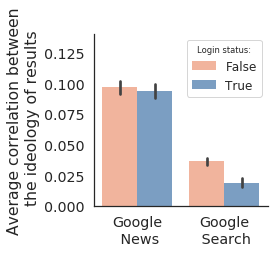

In [13]:
plt.figure(figsize=(4, 3.5))

plt.subplot(1, 1, 1)
x = pd.DataFrame(final1)
x = pd.melt(x,id_vars=[0, 1, 2])

sns.barplot(x=1, y="value", hue=0, data=x, palette=palette, edgecolor="none")

sns.despine()
plt.xlabel("")
plt.ylabel("Average correlation between\n the ideology of results")
plt.xticks([0., 1.], ["Google\n News", "Google\n Search"])
plt.ylim(-0.0, 0.14)
legend = plt.legend(fontsize=12)
legend.set_title("Login status:", prop = {'size':'small'})

plt.tight_layout()

plt.savefig("figures/corr_ideo.pdf".format(a))
plt.show()

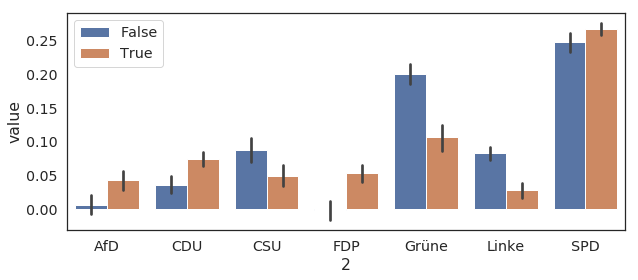

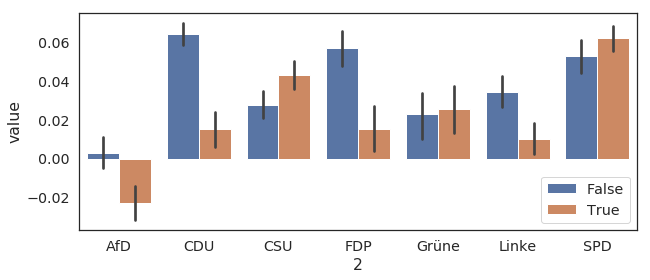

In [14]:
x = pd.DataFrame(final1)
x = pd.melt(x,id_vars=[0, 1, 2, 3])
plt.figure(figsize=(10, 4))
sns.barplot(x=2, y="value", hue=0, data=x.loc[x[1]=="news"])
plt.figure(figsize=(10, 4))
sns.barplot(x=2, y="value", hue=0, data=x.loc[x[1]=="search"])

# Polarization

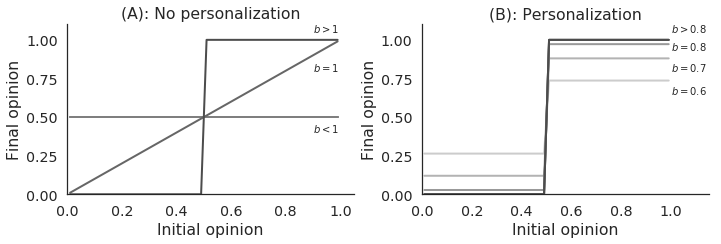

In [15]:
media = np.array([0.8, 0.2])
own_op = 1
p = 0.

## Model

def update(x, w=None):
    #return (own_op*x+x**b*np.mean(media))/(own_op+x**b*np.mean(media) + (1-x)**b*(1-np.mean(media)))
    
#     diffs = np.abs(media-x)
#     f = np.abs(np.diff(diffs))[0]*slope
#     w = np.array([0.5,0.5])
#     w[diffs==np.min(diffs)] += f
#     w[diffs==np.max(diffs)] -= f
    if w is None:
        w = 1-np.abs(x-media)
        w = w/np.sum(w)
#    w = 0.5
    
    #Linear increase
    return (own_op*x+x**(b+p)*np.sum(media*w))/(own_op+x**(b+p)*np.sum(media*w) + (1-x)**(b+p)*(1-np.sum(media*w)))
 
plt.figure(figsize=(10,3.5))

plt.subplot(1, 2, 1)
for b in [0.6,0.7,0.8,0.9,1,1.1]: # XXX np.linspace(0,1.1,12):
    x = [0.01,0.1,0.49,0.51,0.9,0.99]
    v = []
    for i in x:
        for j in range(1000):
            i = update(i, w=0.5)
        v.append(i)
    plt.grid()
    plt.plot(x, v, label=str(b)[:4], color=(1.4-b, 1.4-b, 1.4-b), linewidth=2)
    if b == 1:
        plt.annotate(r"$b=1$", (0.9, 0.8))
    if b == 1.1:
        plt.annotate(r"$b>1$", (0.9, 1.05)) 
    if b == 0.6:
        plt.annotate(r"$b<1$", (0.9, 0.4))
    # print(v[-2])
# plt.legend(title="Assimilation bias")
sns.despine()
plt.xlabel("Initial opinion")
plt.ylabel("Final opinion")
plt.title("(A): No personalization")
plt.ylim(0,1.1)
plt.xlim(0,1.05)

plt.subplot(1, 2, 2)
for b in [0.6,0.7,0.8,0.9,1,1.1]: # XXX np.linspace(0,1.1,12):
    x = [0.01,0.1,0.49,0.51,0.9,0.99]
    v = []
    for i in x:
        for j in range(1000):
            i = update(i)
        v.append(i)
    plt.grid()
    plt.plot(x,v,label=str(b)[:3],color=(1.4-b,1.4-b,1.4-b),linewidth=2)


plt.annotate(r"$b=0.6$", (1.,0.65))
plt.annotate(r"$b=0.7$", (1,0.8))
plt.annotate(r"$b=0.8$", (1,0.93))
plt.annotate(r"$b>0.8$", (1,1.05))

sns.despine()
plt.xlabel("Initial opinion")
plt.ylabel("Final opinion")
plt.title("(B): Personalization")
plt.ylim(0,1.1)
plt.xlim(0,1.15)

plt.tight_layout()
plt.savefig("figures/sim_polarization.pdf")
plt.show()
